In [1]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [2]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [3]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current


,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,temp_kf,dt,dates,h_date,h_time
0,22.27,21.83,18.77,22.27,1003,1003,994,49,3.50,1712599200,2024-04-08 20:00:00,08/04/2024 20:00:00,20
1,19.58,19.08,14.21,19.58,1004,1004,996,57,5.37,1712610000,2024-04-08 23:00:00,08/04/2024 23:00:00,23
2,14.63,13.95,10.81,14.63,1008,1008,1000,69,3.82,1712620800,2024-04-09 02:00:00,09/04/2024 02:00:00,02
3,8.07,4.69,8.07,8.07,1011,1011,1001,77,0.00,1712631600,2024-04-09 05:00:00,09/04/2024 05:00:00,05
4,8.18,5.10,8.18,8.18,1013,1013,1003,67,0.00,1712642400,2024-04-09 08:00:00,09/04/2024 08:00:00,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,14.26,13.99,14.26,14.26,1031,1031,1021,86,0.00,1712977200,2024-04-13 05:00:00,13/04/2024 05:00:00,05
36,13.96,13.68,13.96,13.96,1031,1031,1021,87,0.00,1712988000,2024-04-13 08:00:00,13/04/2024 08:00:00,08
37,17.81,17.42,17.81,17.81,1031,1031,1021,68,0.00,1712998800,2024-04-13 11:00:00,13/04/2024 11:00:00,11
38,21.51,21.10,21.51,21.51,1029,1029,1019,53,0.00,1713009600,2024-04-13 14:00:00,13/04/2024 14:00:00,14


In [4]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('08/04/2024 20:00:00', '13/04/2024 17:00:00')

<Axes: >

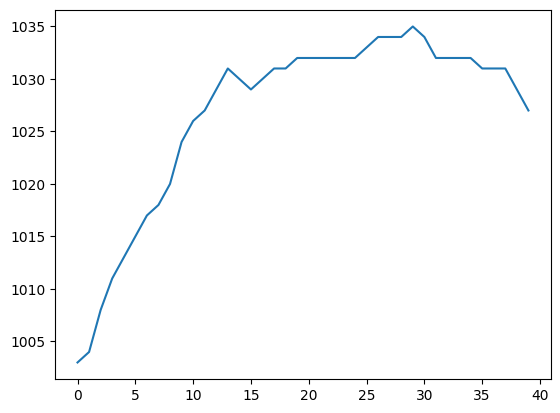

In [5]:
(current.pressure).plot()


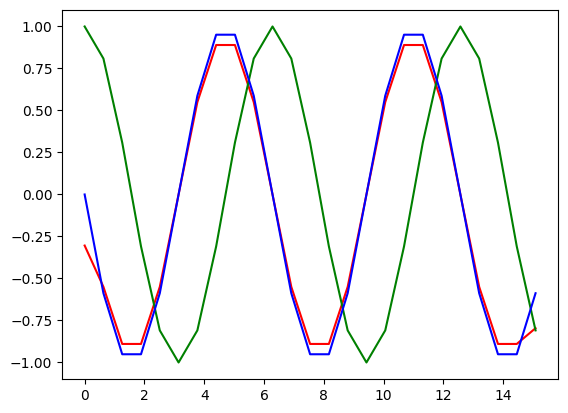

In [6]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

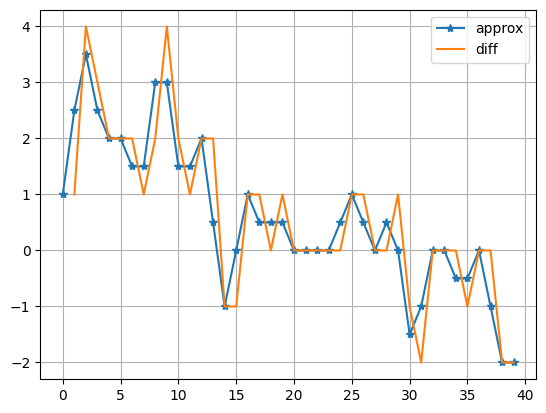

In [7]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


In [8]:
dy.diff()

0     NaN
1     1.0
2     4.0
3     3.0
4     2.0
     ... 
35   -1.0
36    0.0
37    0.0
38   -2.0
39   -2.0
Name: pressure, Length: 40, dtype: float64

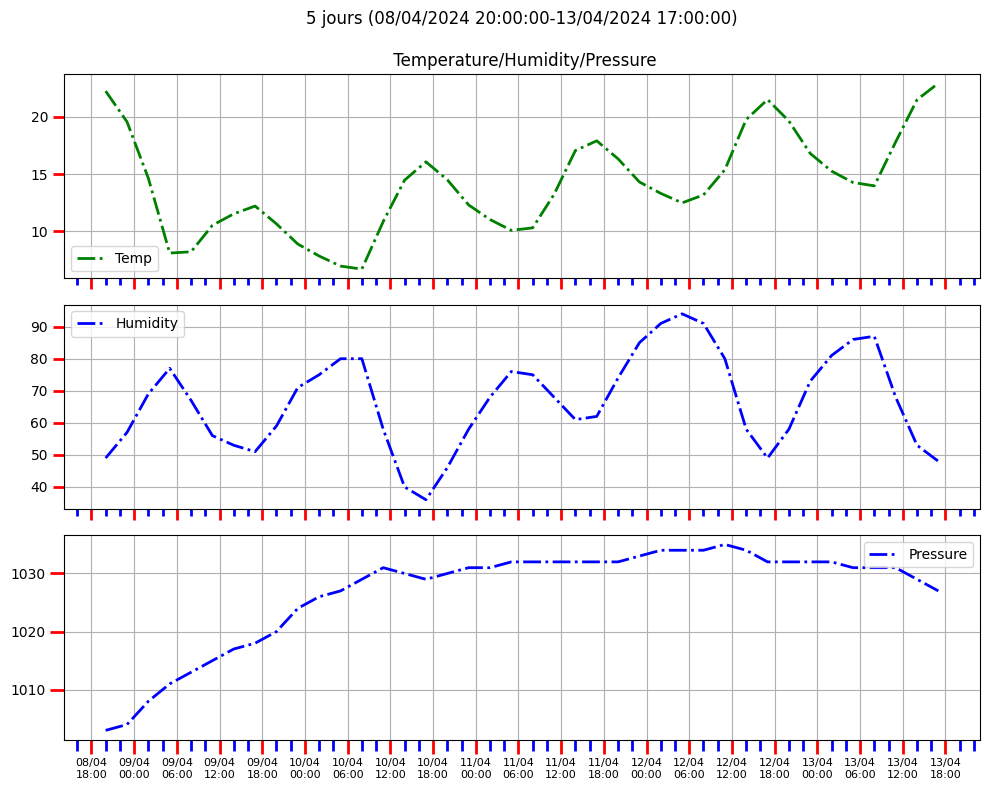

In [9]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

In [10]:
'''Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre
'''
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


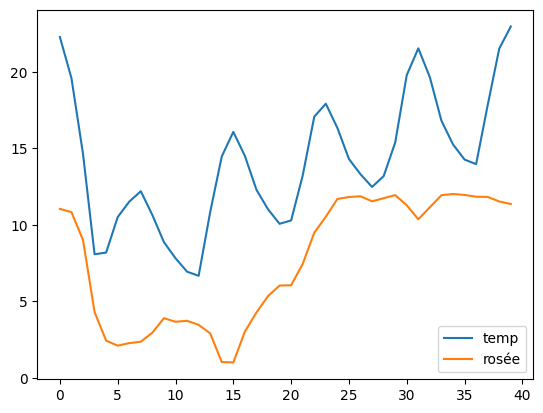

In [11]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='rosée')
plt.legend()


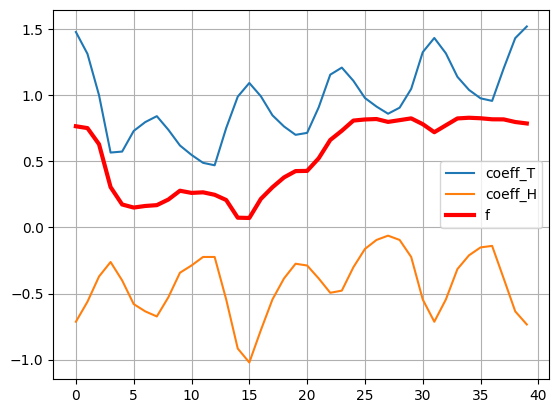

In [12]:
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha()
plt.plot(x,f,label='f',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

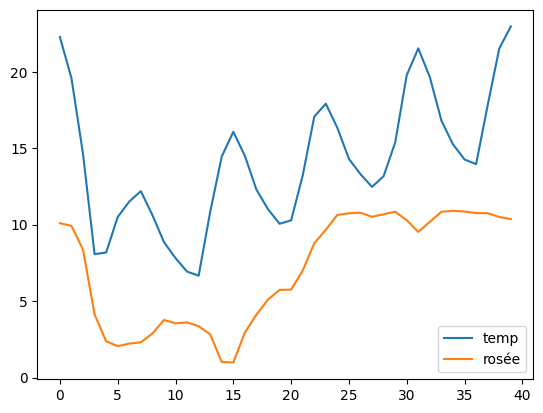

In [13]:
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a+f),label='rosée')
plt.legend()
b,a


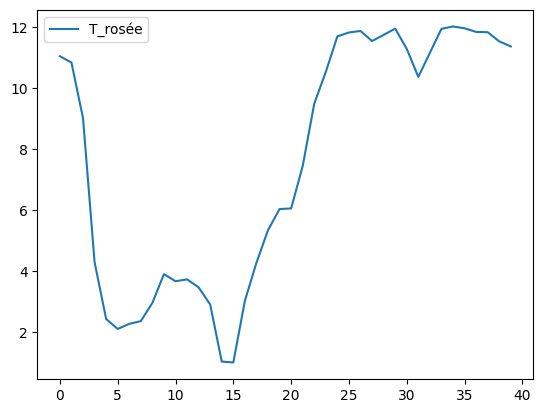

In [14]:
plt.plot(x,b*f/(a-f),label='T_rosée')
plt.legend()

In [15]:

f = y_temp+y_hum
f, alpha(y_temp,x_hum)


(0     0.766063
 1     0.752195
 2     0.630245
 3     0.305706
 4     0.174065
         ...   
 35    0.826595
 36    0.818734
 37    0.818121
 38    0.798237
 39    0.787243
 Length: 40, dtype: float64,
 0    -0.606529
 1    -0.467153
 2    -0.298619
 3    -0.220263
 4    -0.358835
         ...   
 35   -0.080100
 36   -0.069939
 37   -0.298643
 38   -0.531380
 39   -0.624149
 Length: 40, dtype: float64)

In [16]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.713350
 1    -0.562119
 2    -0.371064
 3    -0.261365
 4    -0.400478
         ...   
 35   -0.150823
 36   -0.139262
 37   -0.385662
 38   -0.634878
 39   -0.733969
 Name: humidity, Length: 40, dtype: float64)

In [17]:
dewpoint(current.temp[0],current.humidity[0]/100)

(22.27, 11.033313420767902, 11.236686579232098)

In [18]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt

(0     22.27
 1     19.58
 2     14.63
 3      8.07
 4      8.18
       ...  
 35    14.26
 36    13.96
 37    17.81
 38    21.51
 39    22.96
 Name: temp, Length: 40, dtype: float64,
 0     11.033313
 1     10.824481
 2      9.003084
 3      4.283481
 4      2.420185
         ...    
 35    11.948962
 36    11.829666
 37    11.820373
 38    11.519157
 39    11.352937
 Length: 40, dtype: float64,
 0     11.236687
 1      8.755519
 2      5.626916
 3      3.786519
 4      5.759815
         ...    
 35     2.311038
 36     2.130334
 37     5.989627
 38     9.990843
 39    11.607063
 Length: 40, dtype: float64)

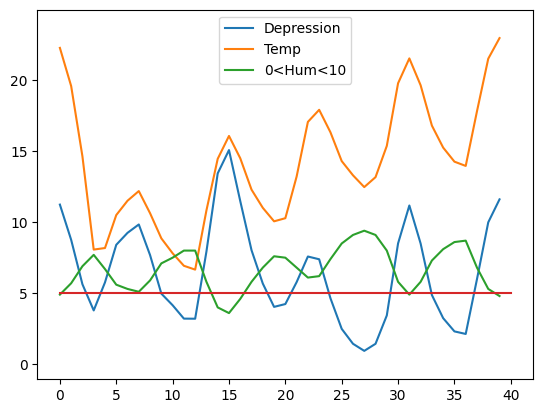

In [19]:
plt.plot(dewpt[2],label='Depression')
plt.plot(current.temp,label='Temp')
plt.plot(current.humidity/10,label='0<Hum<10')
plt.plot((0,40),(5,5))
plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
plt.legend()
plt.show()


In [20]:
current.temp.head(),current.h_time.head()

(0    22.27
 1    19.58
 2    14.63
 3     8.07
 4     8.18
 Name: temp, dtype: float64,
 0    20
 1    23
 2    02
 3    05
 4    08
 Name: h_time, dtype: object)

In [21]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,20,22.27,11.033313
1,23,19.58,10.824481
2,02,14.63,9.003084
3,05,8.07,4.283481
4,08,8.18,2.420185
...,...,...,...
35,05,14.26,11.948962
36,08,13.96,11.829666
37,11,17.81,11.820373
38,14,21.51,11.519157


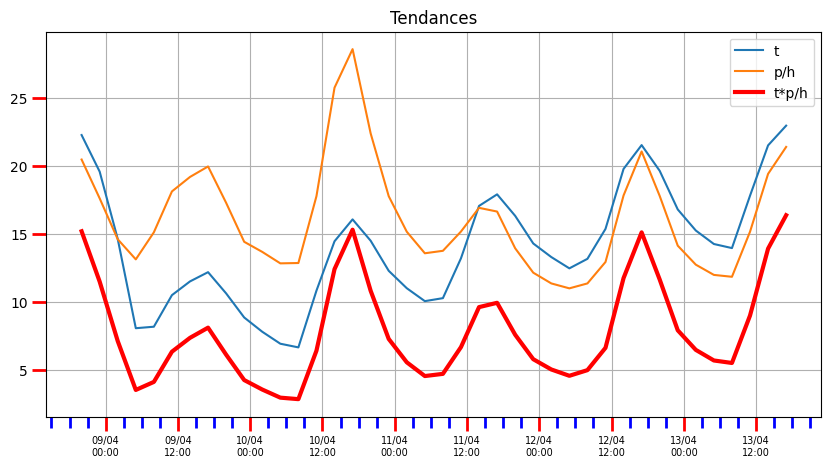

In [22]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

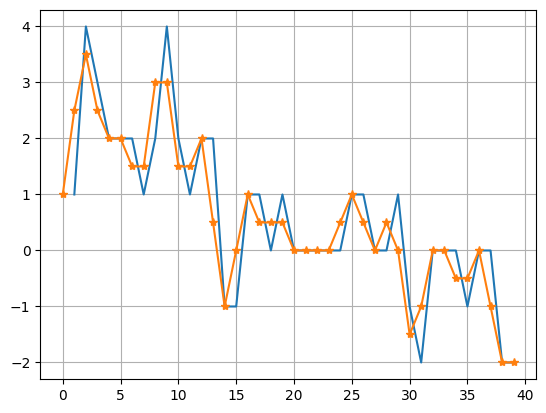

In [23]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [24]:
len(dy)

40

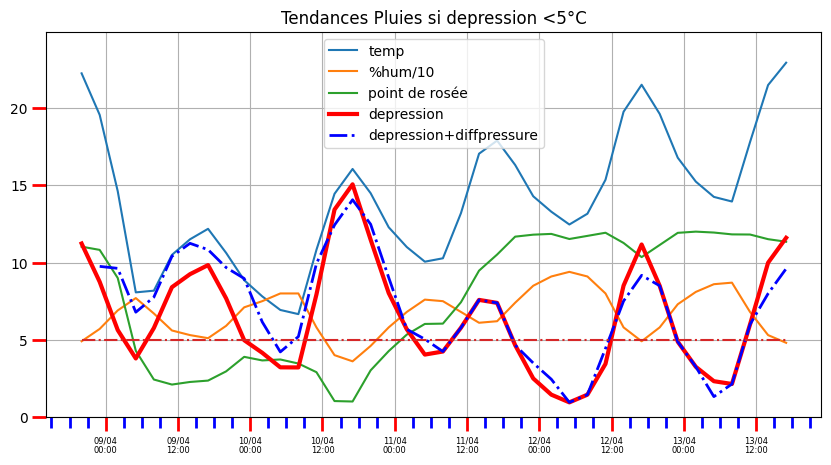

In [25]:
temp = current.temp  
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax = plt.subplots()

# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=6)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, temp,label='temp')
plt.plot(current.dates, current.humidity/10,label='%hum/10')
plt.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
plt.plot(current.dates, depression,label="depression",lw=3,c='red')
plt.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
plt.plot((current.dates[0],current.dates[39]),(5,5),'-.')

plt.ylim(0,max(current.temp)+2)
plt.legend()
plt.title('Tendances Pluies si depression <5°C')
plt.grid()


In [26]:
datetime.now().strftime('%d/%m/%Y %H:%M:%S')

'08/04/2024 19:30:06'

In [27]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')
# 24 h
current[:20][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,08/04/2024 20:00:00,22.27,11.236687,beau temps
1,08/04/2024 23:00:00,19.58,8.755519,beau temps
2,09/04/2024 02:00:00,14.63,5.626916,beau temps
3,09/04/2024 05:00:00,8.07,3.786519,pluie
4,09/04/2024 08:00:00,8.18,5.759815,beau temps
5,09/04/2024 11:00:00,10.50,8.406397,beau temps
6,09/04/2024 14:00:00,11.51,9.248596,beau temps
7,09/04/2024 17:00:00,12.19,9.839376,beau temps
8,09/04/2024 20:00:00,10.63,7.681098,beau temps
9,09/04/2024 23:00:00,8.86,4.969686,pluie


In [28]:
current[20:40][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
20,11/04/2024 08:00:00,10.28,4.235865,pluie
21,11/04/2024 11:00:00,13.21,5.778342,beau temps
22,11/04/2024 14:00:00,17.06,7.582392,beau temps
23,11/04/2024 17:00:00,17.91,7.388498,beau temps
24,11/04/2024 20:00:00,16.33,4.646745,pluie
25,11/04/2024 23:00:00,14.30,2.489271,pluie
26,12/04/2024 02:00:00,13.30,1.439096,pluie
27,12/04/2024 05:00:00,12.47,0.939793,pluie
28,12/04/2024 08:00:00,13.17,1.437609,pluie
29,12/04/2024 11:00:00,15.37,3.434081,pluie


In [29]:
current.h_date

0     08/04/2024 20:00:00
1     08/04/2024 23:00:00
2     09/04/2024 02:00:00
3     09/04/2024 05:00:00
4     09/04/2024 08:00:00
             ...         
35    13/04/2024 05:00:00
36    13/04/2024 08:00:00
37    13/04/2024 11:00:00
38    13/04/2024 14:00:00
39    13/04/2024 17:00:00
Name: h_date, Length: 40, dtype: object